<h1 style="font-size:50px;">Exploratory Data Analysis</h1>

### Import Modules

In [2]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import wordcloud
import plotly.express as px
import spacy
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import LdaMulticore
import pyLDAvis.gensim

nlp = spacy.load("en_core_web_sm")

#### General Functions

In [29]:

def casefolding(data):
    new_str = data.lower()
    return str(new_str)

def remove_non_ascii(data):
    data = unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return data

def remove_digits(data):
    data = re.sub("\d+", " ", data)
    return data

def remove_stopwords(data):
    stop_words =  set(stopwords.words('english'))
    word_tokens = word_tokenize(data)
    sent = [WordNetLemmatizer().lemmatize(w,'v') for w in word_tokens if w not in stop_words and len(w) > 1]
    return " ".join(sent)

def remove_spaces(data):
    data = re.sub(r'[\s]+', ' ', data)
    return data

def remove_hashtag(data):
    data = re.sub(r"#[^\s]+", "", data)
    return data

def remove_special(data):
    data = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", data)
    return data

def preprocess(data):
    # Convert to small case
    data = casefolding(data)
    
    # Remove Non-ASCII values
    data = remove_non_ascii(data)
    
    # Remove Digits
    data = remove_digits(data)
    
    # Remove Hashtag
    data = remove_hashtag(data)
    
    # Remove Special Characters
    data = remove_special(data)
    
    # Remove Stopwords
    data = remove_stopwords(data)
    
    # Remove additional white spaces
    data = remove_spaces(data)
    
    return data

In [42]:
def prepare_lda(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

In [43]:
def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

### Data Extraction

In [30]:
import pandas as pd

# Define the schema
columns = ['Conversation']

# Create an empty DataFrame with the defined schema
df = pd.DataFrame(columns=columns)

with open('D:\TERM 3\AML-3406 Capstone Project\CHATBOT\Final\Machine-Learning\Machine-Learning\Model Training\Datas\Final_merged_data_greet.txt', 'r', encoding='utf-8') as file:
    # Iterate over each line in the file
        lines = file.readlines()

        # Create a DataFrame with one column containing the lines
        df = pd.DataFrame(lines, columns=['Conversation'])
       

In [31]:
df.describe()

,Conversation
count,168238
unique,159807
top,human: how does a counselor decide when to end...
freq,7


In [32]:
df.isnull().sum()

Conversation    0
dtype: int64

### Data Cleaning

In [33]:
df["cleaned_conversation"] = df["Conversation"].apply(preprocess)

In [34]:
df["cleaned_conversation"] = df['cleaned_conversation'].str.replace('human', '').str.replace('gpt', '')

In [35]:
conversations = df["cleaned_conversation"].apply(lambda x: x.split())

corpus = []
for i in conversations:
    for j in i:
        corpus.append(j)

corpus = " ".join(corpus)

### Data Visualisation

### 1. Unigrams and Bigrams

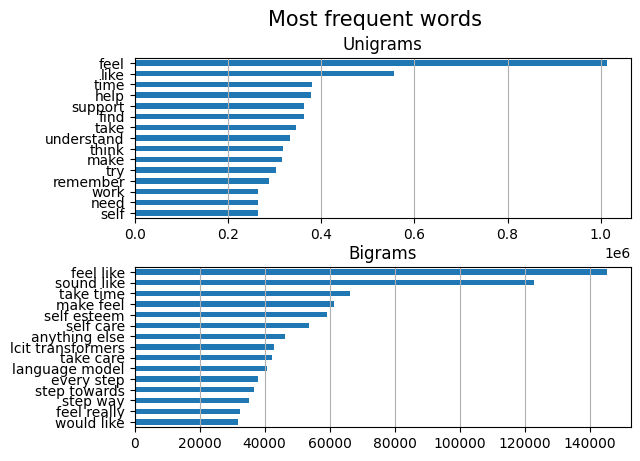

In [36]:
tokens_list = nltk.tokenize.word_tokenize(corpus)

fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)

# Unigrams

word_freq_dict = nltk.FreqDist(tokens_list)
def_uni = pd.DataFrame(word_freq_dict.most_common(), columns=['Word','Freq'])
def_uni.set_index('Word').iloc[:15,:].sort_values(by='Freq').plot(kind='barh', title='Unigrams', ax=ax[0], legend=False).grid(axis='x')

# Bigrams

words_freq_dict2 = nltk.FreqDist(nltk.ngrams(tokens_list, 2))
bi_dtf = pd.DataFrame(words_freq_dict2.most_common(), columns=["Word","Freq"])
bi_dtf["Word"] = bi_dtf["Word"].apply(lambda x: " ".join(string for string in x) )
bi_dtf.set_index("Word").iloc[:15,:].sort_values(by="Freq").plot(kind="barh", title="Bigrams", ax=ax[1],legend=False).grid(axis='x')

ax[0].set(ylabel=None)
ax[1].set(ylabel=None)
plt.subplots_adjust(hspace=0.3)
plt.show()

### 2. Word cloud

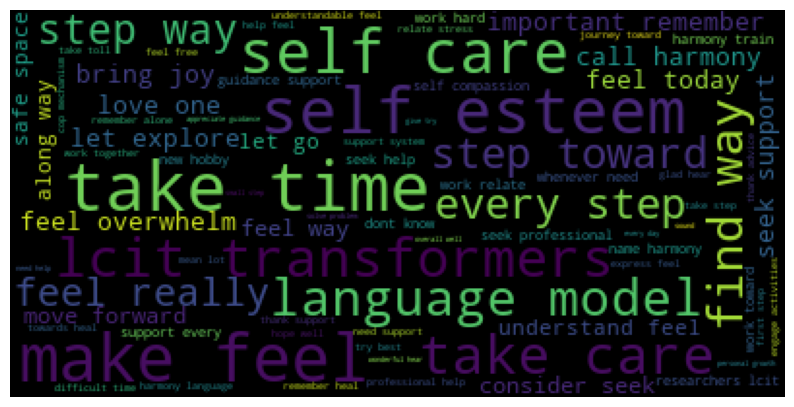

In [40]:
plt.figure(figsize=(10, 6))
wc = wordcloud.WordCloud(background_color='black', max_words=100, max_font_size=35)
wc = wc.generate(corpus)
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

### 3. Latent Dirichlet Allocation (LDA)

In [47]:
preprocessed_documents = [prepare_lda(doc) for doc in df['cleaned_conversation']]

In [48]:
dictionary = Dictionary(preprocessed_documents)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_documents]

tfidf_model = TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]

In [49]:
num_topics = 6
lda_model = LdaMulticore(tfidf_corpus, id2word=dictionary, num_topics=num_topics, workers=14)

In [50]:
topics = lda_model.print_topics(num_topics=25)
for topic in topics:
    print(topic)

(0, '0.006*"anxiety" + 0.006*"stress" + 0.005*"addiction" + 0.004*"therapy" + 0.004*"work" + 0.003*"manage" + 0.003*"self" + 0.003*"strategy" + 0.003*"relate" + 0.003*"overwhelm"')
(1, '0.006*"child" + 0.005*"parent" + 0.004*"paint" + 0.004*"anxiety" + 0.004*"self" + 0.004*"hobby" + 0.003*"new" + 0.003*"conflict" + 0.003*"family" + 0.003*"addiction"')
(2, '0.005*"grief" + 0.005*"heal" + 0.004*"self" + 0.003*"dream" + 0.003*"new" + 0.003*"paint" + 0.003*"addiction" + 0.003*"breakup" + 0.003*"heartbreak" + 0.003*"joy"')
(3, '0.006*"grief" + 0.006*"heal" + 0.005*"self" + 0.005*"heartbreak" + 0.005*"breakup" + 0.003*"esteem" + 0.003*"relationship" + 0.003*"dream" + 0.003*"love" + 0.003*"pain"')
(4, '0.006*"conflict" + 0.005*"dream" + 0.004*"friendship" + 0.004*"friend" + 0.004*"family" + 0.004*"relationship" + 0.003*"self" + 0.003*"conversation" + 0.003*"communication" + 0.003*"esteem"')
(5, '0.004*"conflict" + 0.004*"health" + 0.004*"relationship" + 0.003*"family" + 0.003*"issue" + 0.003*

In [51]:
plot_lda_vis(lda_model, tfidf_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.022549 -0.019498       1        1  24.210455
5     -0.023940  0.009274       2        1  18.254586
3      0.021371 -0.010823       3        1  16.952980
0     -0.000850  0.025252       4        1  16.919500
2      0.035195 -0.000083       5        1  13.615729
1     -0.009226 -0.004123       6        1  10.046750, topic_info=            Term         Freq        Total Category  logprob  loglift
1078       grief  3000.000000  3000.000000  Default  30.0000  30.0000
931        child  1686.000000  1686.000000  Default  29.0000  29.0000
2347  heartbreak  2325.000000  2325.000000  Default  28.0000  28.0000
452        paint  2204.000000  2204.000000  Default  27.0000  27.0000
349      anxiety  3785.000000  3785.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
190      journey   274.595664  2920.368330   Topic6  -6.2293  -0.0662
13          care   272.849367  2938.521457   Topic6  -6.2357  -0.0788
175       friend   277.054565  3699.014015   Topic6  -6.2204  -0.2937
117         step   266.073771  2959.164280   Topic6  -6.2608  -0.1110
68          like   261.862555  2798.769166   Topic6  -6.2768  -0.0712

[587 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2109      1  0.100704  abuse
2109      2  0.132249  abuse
2109      3  0.076438  abuse
2109      4  0.137103  abuse
2109      5  0.479253  abuse
...     ...       ...    ...
240       2  0.134514  worth
240       3  0.231556  worth
240       4  0.142201  worth
240       5  0.148926  worth
240       6  0.089836  worth

[1768 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 4, 1, 3, 2])

### Intent Classification

In [3]:
intent_df = pd.read_csv('D:/TERM 3/AML-3406 Capstone Project/CHATBOT/Final/Machine-Learning/Machine-Learning/Model Training/Datas/Final_Intent_Data.csv')

In [4]:
intent_df

,text,intent
0,human: do you feel that you are frail and sick...,Depression
1,the tone in which my boyfriend talks to me ma...,Social Anxiety
2,i feel depressed and no longer want to take m...,Depression
3,"confused at work, confused in life, and witho...",Stress
4,why do you always treat your family members p...,Social Anxiety
...,...,...
168120,"hi, i'm feeling really stressed and i think i...",Stress
168121,"hi, i've been feeling really stressed lately ...",Stress
168122,"hi, i hope you're doing well. i'm feeling rea...",Anxiety
168123,i feel so ashamed. i've been grappling with t...,Social Anxiety


In [30]:
avg_price = intent_df.groupby(["intent"]).agg({"text" : "count"}).reset_index().sort_values(by="text", ascending=False)
avg_price

,intent,text
6,Stress,46280
2,Greeting,40842
0,Anxiety,28621
5,Social Anxiety,24400
1,Depression,17766
3,Mood Swing,10142
4,Panic Attack,74


In [31]:
record = {'intent': 'Other', 'text': '10216'}
avg_price.loc[len(avg_price)] = record
avg_price

,intent,text
6,Stress,46280
2,Greeting,40842
0,Anxiety,28621
5,Social Anxiety,24400
1,Depression,17766
3,Mood Swing,10142
4,Panic Attack,74
7,Other,10216


In [29]:
record = {'intent': 'Other', 'text': '10216'}
avg_price.loc[len(avg_price)] = record
avg_price

,intent,text
6,Stress,46280
2,Greeting,40842
0,Anxiety,28621
5,Social Anxiety,24400
1,Depression,17766
3,Mood Swing,10142
4,Panic Attack,74
7,Other,10216


In [35]:
avg_price = avg_price[(avg_price['intent']!='Mood Swing') & (avg_price['intent']!='Panic Attack')]
avg_price

,intent,text
6,Stress,46280
2,Greeting,40842
0,Anxiety,28621
5,Social Anxiety,24400
1,Depression,17766
7,Other,10216


In [36]:
fig = px.bar(avg_price, x='intent', y='text',text_auto='.2s', labels={"intent" : "Intent", "text" : "Count"})
fig.update_layout(title_text='Intent Classification', title_x=0.5, width=1000, height=650)
fig.show()